In [1]:
import csv
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import arff
import pandas as pd
import scipy.stats as stats
import seaborn as sns
sns.set(style="dark")
import pywt
from scipy.special import erfcinv
from scipy.signal import butter, convolve

from tqdm import tqdm

# Algorithms

In [2]:
def iterativeWaveletDenoising( signal, waveletname, level, alpha_1, mode = "soft"):
    coeffs = pywt.wavedec(signal, waveletname, level = level) 


    details = coeffs[1:]

    new_details = []

    alpha = alpha_1

    for detail in details:
        new_detail = detail.copy()
        s = np.std(detail, ddof=0)
        d = np.sqrt(2) * erfcinv(alpha)
        while (np.abs(detail) > s*d).any():
            indices_to_delete = np.argwhere(np.abs(detail) > s*d)
            detail = np.delete(detail, indices_to_delete)
            s = np.std(detail)



            
        threshold = s*d

        new_detail = pywt.threshold(new_detail, threshold, mode=mode)
        new_details.append(new_detail)
        alpha += alpha_1

    new_coeffs = [coeffs[0]] + new_details
    denoised_signal = pywt.waverec(new_coeffs, waveletname)

    return denoised_signal


def baselineWaveletDenoising(signal, waveletname, level, threshold_percent= 0.9, mode = "soft"):
    coeffs = pywt.wavedec(signal, waveletname, level = level) 
    details = coeffs[1:]
    new_details = []
    for detail in details:
        #Méthode de base : on prend le seuil à 0.9*max (tous ceux en dessous sont tronqués)
        threshold = threshold_percent*np.max(detail)
        new_detail = pywt.threshold(detail, threshold, mode="soft")
        new_details.append(new_detail)

    new_coeffs = [coeffs[0]] + new_details
    denoised_signal = pywt.waverec(new_coeffs, waveletname)

    return denoised_signal

In [3]:
def metrics(signal, denoised_signal):

    #MSE
    rmse = np.mean((signal - denoised_signal)**2)**0.5

    #SNR
    snr = 10*np.log10(np.var(signal)/np.var(signal - denoised_signal))

    prd = np.sqrt( (np.sum(np.square(signal - denoised_signal))) / (np.sum(np.square(signal))))

    d_max = np.max (np.abs(signal - denoised_signal))

    return rmse, snr, prd, d_max

In [4]:
def mdct_atoms(signal, L, k):
    """
    Returns the MDCT atom for a scale L  and frequency k, 0-padded to match the length of the signal.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    L : int
        The scale of the MDCT atom.
    k : int
        The frequency of the MDCT atom.

    Returns
    -------
    array_like, shape (N,)
        The MDCT atom for a scale L (length 2L)  and frequency k, 0-padded to match the length of the signal.
    """
    N = len(signal)
    u = np.arange(0, 2*L - 1, 1)
    res = np.sin(np.pi * (u +0.5) / (2*L)) * np.sqrt(2/L) * np.cos( (np.pi /L) * (u + 0.5*(L+1)) * (k + 0.5) )
    if N > 2*L - 1:
        return np.hstack((res, np.zeros(N - (2*L - 1))))
    return

def buildDictionary(signal, Ls):
    """
    Returns the whole dictionary of MDCT atoms for a given signal and list of scale Ls.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    Ls : list
        The list of scales for the MDCT atoms.

    Returns
    -------
    array_like, shape (N, len(Ls))
        The whole dictionary of MDCT atoms for a given signal and list of scale Ls.
    """

    N = len(signal)
    dictionary = np.zeros((N, 1))
    for L in Ls:
        for k in range(L):
            dictionary = np.hstack((dictionary, mdct_atoms(signal, L, k).reshape((N, 1))))
    return dictionary[:, 1:]

def orthogonalMatchingPursuit(signal, D, K):
    """
    Returns the indices of the K atoms of the dictionary D that best match the signal.

    Parameters
    ----------
    signal : array_like, shape (N,)
        The signal to be represented.
    D : array_like, shape (N, M)
        The dictionary of MDCT atoms.
    K : int
        The number of atoms to select.

    Returns
    -------
    support: array_like, shape (N, K)
        The indices of the K atoms of the dictionary D that best match the signal. Each atom is a column of D suitably shifted, see "Placement" in the code.
    norm_residuals: array_like, shape (K+1,)
        The norm of the residual at each iteration.
    reconstruction: array_like, shape (N,)
        The reconstruction of the signal (projection over the selected atoms)
    """
    N = len(signal)
    residual = signal
    norm_residuals = [np.linalg.norm(residual)]
    support = np.empty((N, K))
    flipDic = np.flipud(D)
    for _ in range(K):
        #We compute the full convolution of each atom with the signal
        convolutions = np.abs(convolve(residual.reshape(-1,1), flipDic, mode='full')) #shape (4095, 2016)
        correlations = np.max(convolutions,axis=0) #shape (2016,). We take the max of each column (correlation of each atom = max of the convolution)
        index_atom = np.argmax(correlations) #Best correlation

        #"Placement" of the atom in a (2048, ) vector
        start=np.argmax(convolutions[: , index_atom])
        begin=max(start-(N-1),0)
        end =min(start,N-1)

        atom=np.hstack((np.zeros(begin),D[begin+(N-1)-start:end+(N-1)-start,index_atom],np.zeros(N-end)))

        #Update support
        support[:, _] = atom.reshape((N, ))
        support[:, :_] /= np.linalg.norm(support[:, :_], axis = 0) #Normalization, because we will project using pseudo-inverse

        #Update residual
        S = support[:, :_+1]

        try :
            STS_inv = np.linalg.inv(S.T@S)
        except np.linalg.LinAlgError:
            eps = 10**(-6)
            STS_inv = np.linalg.inv(S.T@S + eps*np.eye(S.shape[1]))
        reconstruction = S@STS_inv@S.T@signal
        residual = signal - reconstruction
        norm_residuals.append(np.linalg.norm(residual))

    return support, norm_residuals, reconstruction




# Data loading and noising

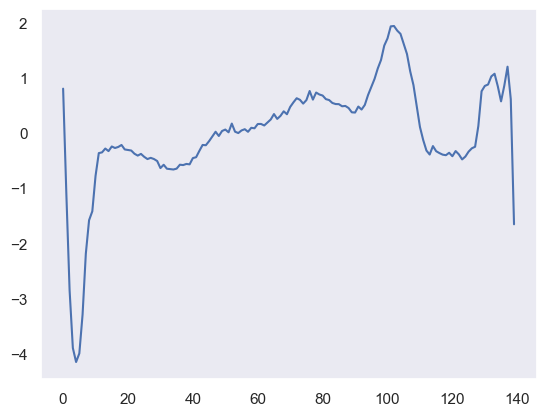

In [53]:
#Importation of signal 
# Load ARFF file
data, meta = arff.loadarff('ECG5000_TRAIN.arff')

# Convert to DataFrame
df = pd.DataFrame(data)
df = df[df['target'] == b'1'].copy() #keep only the first class
df.drop('target', axis=1, inplace=True) #drop the class number

i = 16
line = df.iloc[i]

line = line.astype(float).tolist()

#Normalize signal
line = line

plt.plot([i for i in range(len(line))],line)
plt.show()

Original RMSE :  0.34077788597556324
Original SNR :  9.332528221113174


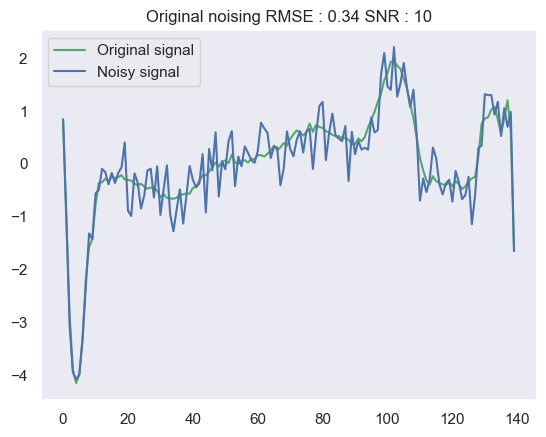

Input SNR :  9.332528221113174


In [75]:
def addNoise(line, SNR):
    log_ratio = SNR / 10
    noise_variance = np.var(line) / (10 ** log_ratio)
    noise = np.sqrt(noise_variance) * np.random.randn(len(line))
    return line + noise, noise_variance, noise

def addNoise2(line, noise_var):
    noise = np.sqrt(noise_var) * np.random.randn(len(line))
    SNR = 10 * np.log10(np.var(line) / np.var(noise))
    return line + noise, SNR, noise

noisy_line, noise_var , noise = addNoise(line, 10)
rmse, snr, prd, d_max = metrics(line, noisy_line)
print("Original RMSE : ", rmse)
print("Original SNR : ", snr)


plt.plot(line, 'g', label = "Original signal")
plt.plot(noisy_line, label = "Noisy signal")
plt.title("Original noising RMSE : " + str(round(rmse, 2)) + " SNR : " + str(10))
plt.legend()
plt.show()



print("Input SNR : ", snr)

# Algorithms training

In [76]:
levels = [2,3,4]
res = np.zeros((len(pywt.wavelist()), len(levels)))
best_prd = 1

for i, waveletname in tqdm(enumerate(pywt.wavelist(kind = 'discrete'))):
    for j, level in enumerate(levels):
        denoised_line = iterativeWaveletDenoising(noisy_line, waveletname, level, 0.01)
        mse, snr, prd, d_max = metrics(line, denoised_line)
        res[i, j] = prd
        if prd < best_prd:
            best_prd = prd
            best_wavelet = waveletname
            best_level = level
        
print("--------------")
print(best_prd)
print(best_wavelet)
print(best_level)
    

0it [00:00, ?it/s]/Users/Meilame/opt/anaconda3/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 4 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/Meilame/opt/anaconda3/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/Users/Meilame/opt/anaconda3/lib/python3.8/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
106it [00:00, 767.38it/s]

--------------
0.19267825687384568
bior3.7
2


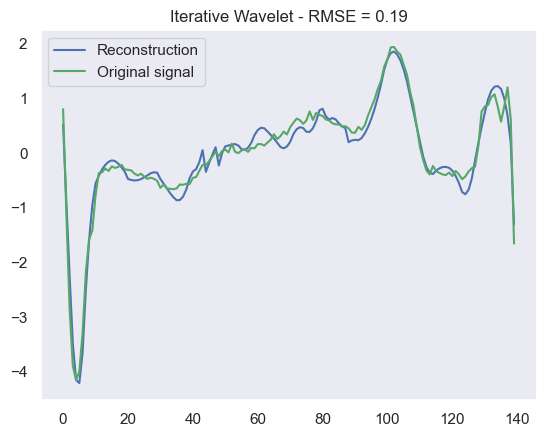

In [77]:
denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, 0.015)
mse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Iterative Wavelet - RMSE = " + str(round(mse,2)))
plt.legend()
plt.show()

100%|██████████| 20/20 [00:00<00:00, 2657.40it/s]

Best threshold :  0.33684210526315794


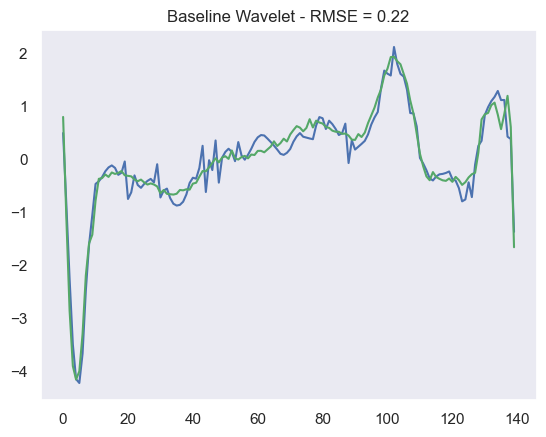

In [78]:
threshold_percents = np.linspace(0.1, 1, 20)

best_prd = 1

for thresh in tqdm(threshold_percents):
    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, thresh)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    if prd < best_prd:
        best_prd = prd
        best_thresh_wave = thresh

print("Best threshold : ", best_thresh_wave)
denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave) #j'ai remplace tresh par best_tresh
mse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Baseline Wavelet - RMSE = " + str(round(mse,2)))
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 9562.94it/s]

Best threshold :  0.12696969696969698


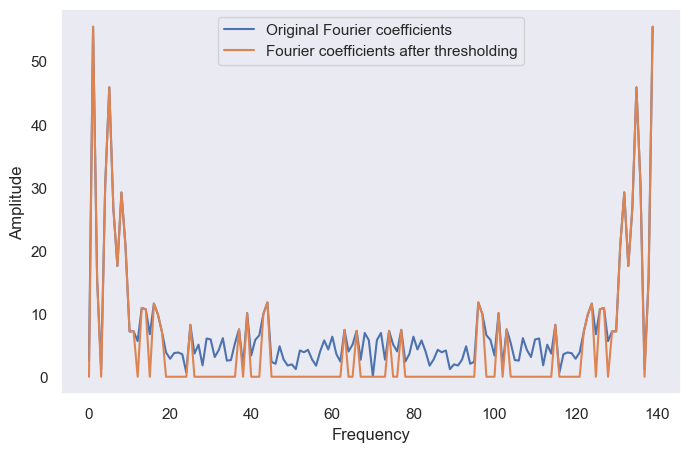

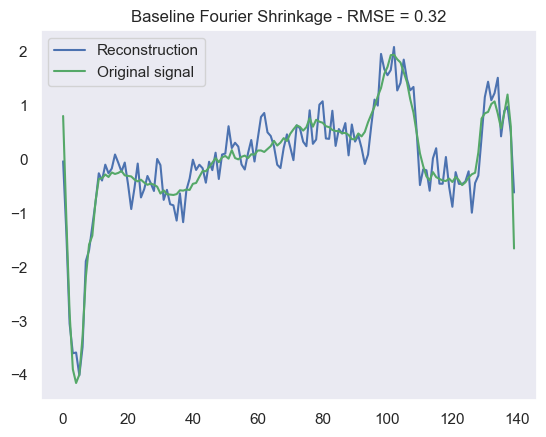

In [79]:
fourier = np.fft.fft(noisy_line)
threshold_percents = np.linspace(0.1, 0.99, 100)

best_prd = 5

for thresh in tqdm(threshold_percents):
    fourier_shrink = fourier * (np.abs(fourier) > thresh*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    rmse, snr, prd, d_max = metrics(line, denoised_line)
    if prd < best_prd:
        best_prd = prd
        best_thresh_fourier = thresh


fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
denoised_line = np.real(np.fft.ifft(fourier_shrink))
print("Best threshold : ", best_thresh_fourier)


plt.figure(figsize = (8, 5))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.plot(np.abs(fourier), label = "Original Fourier coefficients")
plt.plot(np.abs(fourier_shrink), label = "Fourier coefficients after thresholding")
plt.legend()

plt.show()

rmse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Baseline Fourier Shrinkage - RMSE = " + str(round(rmse, 2)))
plt.legend()
plt.show()



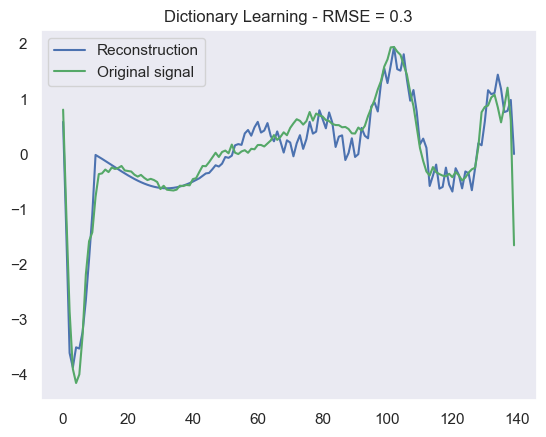

In [80]:
D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
rmse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.legend()
plt.title("Dictionary Learning - RMSE = " + str(round(rmse, 2)))
plt.show()

# On another "test" signal ?

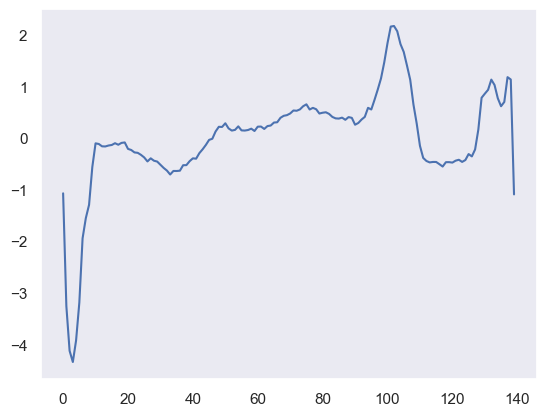

In [47]:
#Importation of signal 
# Load ARFF file
data, meta = arff.loadarff('ECG5000_TRAIN.arff')

# Convert to DataFrame
df = pd.DataFrame(data)
df = df[df['target'] == b'1'].copy() #keep only the first class
df.drop('target', axis=1, inplace=True) #drop the class number

i = 12
line = df.iloc[i]

line = line.astype(float).tolist()

#Normalize signal
line = line

plt.plot([i for i in range(len(line))],line)
plt.show()

Original RMSE :  0.3179214370878233
Original SNR :  9.94568946458385


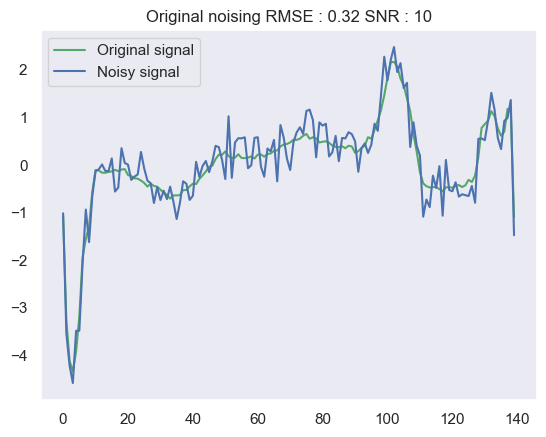

Input SNR :  9.94568946458385


In [48]:
noisy_line, noise_var , noise = addNoise(line, 10)
rmse, snr, prd, d_max = metrics(line, noisy_line)
print("Original RMSE : ", rmse)
print("Original SNR : ", snr)


plt.plot(line, 'g', label = "Original signal")
plt.plot(noisy_line, label = "Noisy signal")
plt.title("Original noising RMSE : " + str(round(rmse, 2)) + " SNR : " + str(10))
plt.legend()
plt.show()



print("Input SNR : ", snr)

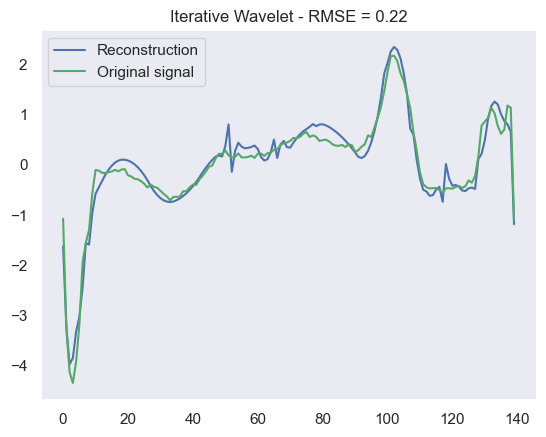

In [49]:
denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, 0.015)
mse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Iterative Wavelet - RMSE = " + str(round(mse,2)))
plt.legend()
plt.show()

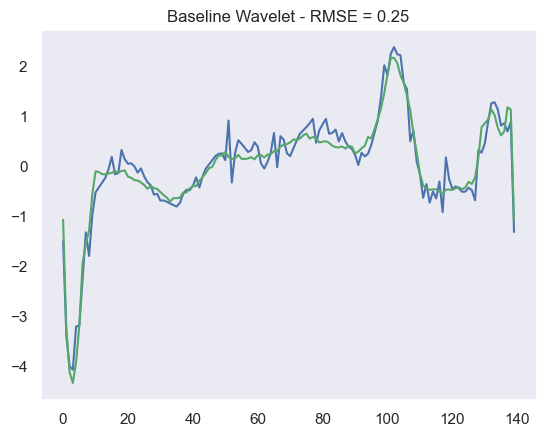

In [50]:
denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave)
mse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Baseline Wavelet - RMSE = " + str(round(mse,2)))
plt.show()

Best threshold :  0.1131578947368421


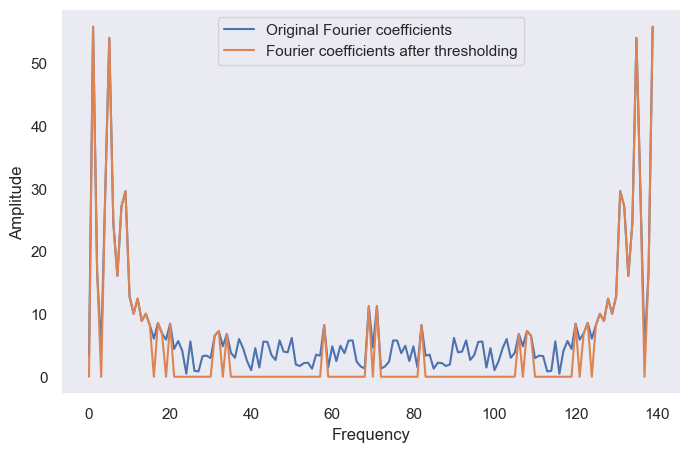

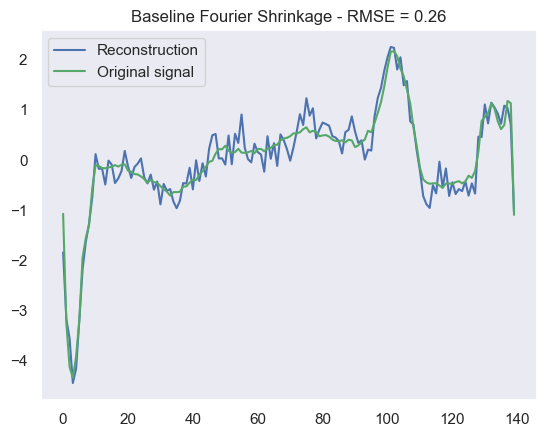

In [51]:
fourier = np.fft.fft(noisy_line)
fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
denoised_line = np.real(np.fft.ifft(fourier_shrink))
print("Best threshold : ", best_thresh_fourier)



plt.figure(figsize = (8, 5))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.plot(np.abs(fourier), label = "Original Fourier coefficients")
plt.plot(np.abs(fourier_shrink), label = "Fourier coefficients after thresholding")
plt.legend()

plt.show()

rmse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.title("Baseline Fourier Shrinkage - RMSE = " + str(round(rmse, 2)))
plt.legend()
plt.show()

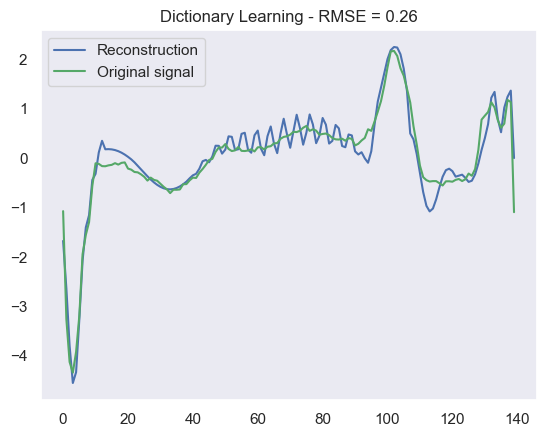

In [52]:
D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
rmse, snr, prd, d_max = metrics(line, denoised_line)
plt.plot(denoised_line, label = "Reconstruction")
plt.plot(line, 'g', label = "Original signal")
plt.legend()
plt.title("Dictionary Learning - RMSE = " + str(round(rmse, 2)))
plt.show()

# Test - Varying noise - Algorithms comparison

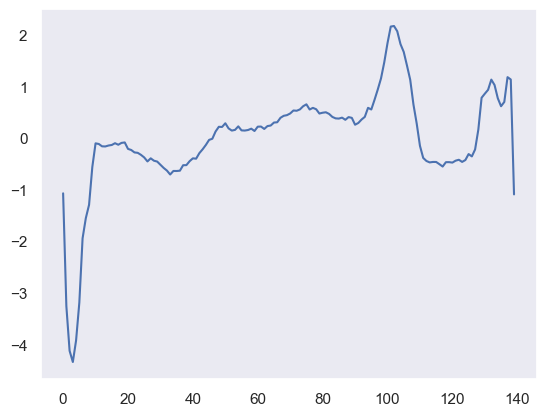

In [90]:
#Importation of signal 
# Load ARFF file
data, meta = arff.loadarff('ECG5000_TRAIN.arff')

# Convert to DataFrame
df = pd.DataFrame(data)
df = df[df['target'] == b'1'].copy() #keep only the first class
df.drop('target', axis=1, inplace=True) #drop the class number

i = 12
line = df.iloc[i]

line = line.astype(float).tolist()

#Normalize signal
line = line

plt.plot([i for i in range(len(line))],line)
plt.show()

In [91]:
list_SNR = [i for i in range(20)] #the list of SNR noises we want to try
precision = 3

#list of parameters we are going to test 
levels = [2,3,4]
alpha_1 = 0.015

threshold_percents = np.linspace(0.1, 1, 20)

threshold_percents_fourier = np.linspace(0.1, 0.99, 20)


#building the dataframe to store the results 
columns_name = ["SNR = " + str(list_SNR[i]) for i in range(len(list_SNR))]
lines_name = ["Iterative Wavelet", "Basic Wavelet", "Fourier Shrink", "Dictionnary Method"]
res_df = pd.DataFrame(index = lines_name, columns=columns_name)

for k in tqdm(range(len(list_SNR))):
    noisy_line, _, noise = addNoise(line, list_SNR[k])
        
    denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, alpha_1)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[0],columns_name[k]] = round(mse,precision)

    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave) 
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[1],columns_name[k]] = round(mse,precision)

    fourier = np.fft.fft(noisy_line)
    fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[2],columns_name[k]] = round(mse,precision)

    #dictionnary method
    D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
    support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[3],columns_name[k]] = round(mse,precision)

            

res_df

100%|██████████| 20/20 [00:00<00:00, 92.53it/s]


,SNR = 0,SNR = 1,SNR = 2,SNR = 3,SNR = 4,SNR = 5,SNR = 6,SNR = 7,SNR = 8,SNR = 9,SNR = 10,SNR = 11,SNR = 12,SNR = 13,SNR = 14,SNR = 15,SNR = 16,SNR = 17,SNR = 18,SNR = 19
Iterative Wavelet,0.536,0.631,0.432,0.486,0.428,0.347,0.341,0.316,0.246,0.248,0.222,0.259,0.166,0.165,0.138,0.147,0.145,0.118,0.132,0.11
Basic Wavelet,0.645,0.705,0.531,0.509,0.455,0.391,0.352,0.347,0.261,0.239,0.233,0.236,0.202,0.185,0.16,0.164,0.153,0.168,0.152,0.166
Fourier Shrink,1.022,0.982,0.76,0.681,0.589,0.479,0.435,0.366,0.31,0.252,0.258,0.268,0.217,0.19,0.178,0.197,0.184,0.169,0.187,0.173
Dictionnary Method,0.852,0.775,0.606,0.61,0.497,0.421,0.337,0.35,0.261,0.273,0.227,0.289,0.234,0.23,0.202,0.224,0.209,0.235,0.189,0.208


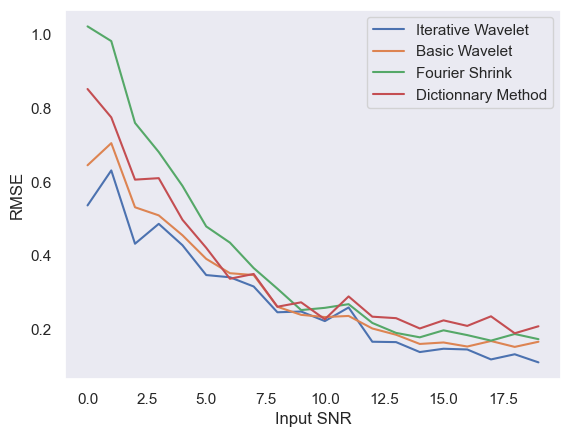

In [92]:
for i in range(len(lines_name)):
    plt.plot(list_SNR, res_df.iloc[i,:], label = lines_name[i])
plt.legend()
plt.xlabel("Input SNR")
plt.ylabel("RMSE")
plt.show()

In [93]:
list_SNR = [i for i in range(20)] #the list of SNR noises we want to try
precision = 3

#list of parameters we are going to test 
levels = [2,3,4]
alpha_1 = 0.015

threshold_percents = np.linspace(0.1, 1, 20)

threshold_percents_fourier = np.linspace(0.1, 0.99, 20)


#building the dataframe to store the results 
columns_name = ["SNR = " + str(list_SNR[i]) for i in range(len(list_SNR))]
lines_name = ["Iterative Wavelet", "Basic Wavelet", "Fourier Shrink", "Dictionnary Method"]
res_df = pd.DataFrame(index = lines_name, columns=columns_name)

for k in tqdm(range(len(list_SNR))):
    noisy_line, _, noise = addNoise(line, list_SNR[k])
        
    denoised_line = iterativeWaveletDenoising(noisy_line, best_wavelet, best_level, alpha_1)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[0],columns_name[k]] = round(snr,precision)

    denoised_line = baselineWaveletDenoising(noisy_line, best_wavelet, best_level, best_thresh_wave) 
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[1],columns_name[k]] = round(snr,precision)

    fourier = np.fft.fft(noisy_line)
    fourier_shrink = fourier * (np.abs(fourier) > best_thresh_fourier*np.max(np.abs(fourier)))
    denoised_line = np.real(np.fft.ifft(fourier_shrink))
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[2],columns_name[k]] = round(snr,precision)

    #dictionnary method
    D = buildDictionary(noisy_line, [2, 4, 8, 16, 32, 64])
    support, norm_residuals, denoised_line = orthogonalMatchingPursuit(noisy_line, D, 10)
    mse, snr, prd, d_max = metrics(line, denoised_line)
    res_df.at[lines_name[3],columns_name[k]] = round(snr,precision)

            

res_df

100%|██████████| 20/20 [00:00<00:00, 104.61it/s]


,SNR = 0,SNR = 1,SNR = 2,SNR = 3,SNR = 4,SNR = 5,SNR = 6,SNR = 7,SNR = 8,SNR = 9,SNR = 10,SNR = 11,SNR = 12,SNR = 13,SNR = 14,SNR = 15,SNR = 16,SNR = 17,SNR = 18,SNR = 19
Iterative Wavelet,4.739,5.648,6.93,6.136,7.561,8.483,11.814,11.592,12.57,10.891,12.749,13.124,14.522,15.208,16.495,15.16,17.242,16.506,17.286,19.267
Basic Wavelet,3.981,3.95,5.912,5.669,7.282,8.097,10.31,10.691,11.18,10.282,12.075,13.476,13.644,14.024,14.667,13.896,14.679,15.339,15.32,16.145
Fourier Shrink,0.54,1.265,2.114,2.903,5.031,6.029,8.455,9.567,10.564,10.246,10.359,13.612,13.299,13.193,14.396,14.712,15.04,14.088,14.333,15.306
Dictionnary Method,2.299,3.604,4.058,5.82,6.525,7.12,8.998,10.455,10.769,11.916,10.82,13.273,13.739,12.102,13.455,13.874,13.935,14.163,14.796,15.326


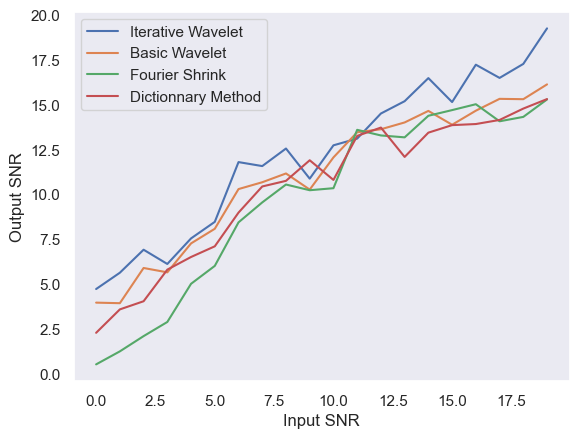

In [95]:
for i in range(len(lines_name)):
    plt.plot(list_SNR, res_df.iloc[i,:], label = lines_name[i])
plt.legend()
plt.xlabel("Input SNR")
plt.ylabel("Output SNR")
plt.show()